# 0. About

This notebook is to check out Covariance Estimation mentioned in https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html

There are two methods that can be tested in this notebook:
- [`sklearn.covariance.MinCovDet`](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html)
- [`sklearn.covariance.EllipticEnvelope`](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.covariance import MinCovDet, EllipticEnvelope
from sklearn.utils import Bunch
from scipy.stats import chi2

rs_num = 7
rng = np.random.default_rng(rs_num)

# 1. Construct Dataset

In [2]:
# the dataset is consistent with the sklearn example
n_samples = 125
n_outliers = 25
n_features = 2

mean_vec = np.array(([3.0, 5.0]))
cov_mat = np.eye(n_features)
cov_mat = np.array((
    [1.5, 0.0], 
    [0.0, 1.5]
))

outliers_cov_mat = np.array((
    [2.0, 0.0], 
    [0.0, 8.0]
))

X = rng.multivariate_normal(
    mean_vec, cov_mat, size=n_samples
)
X[-n_outliers:, :] = rng.multivariate_normal(
    mean_vec, outliers_cov_mat, size=n_outliers
)

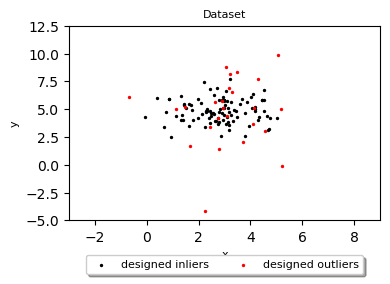

In [3]:
# visualize data
fig, ax = plt.subplots(figsize=(4, 3))
marker_size = 8
font_size = 8
xlim = [-3, 9]
ylim = [-5, 12.5]

# dataset plot
ax.scatter(
    X[:-n_outliers, 0], X[:-n_outliers, 1], 
    marker='.', s=marker_size, c='black', 
    label='designed inliers'
)
ax.scatter(
    X[-n_outliers:, 0], X[-n_outliers:, 1], 
    marker='.', s=marker_size, c='red', 
    label='designed outliers'
)
ax.set_xlabel('x', fontsize=font_size)
ax.set_ylabel('y', fontsize=font_size)
ax.set_title('Dataset', fontsize=font_size)
ax.set(xlim=xlim, ylim=ylim)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    ncol=2,
    fontsize=font_size
)
fig.tight_layout()

# 2. Apply Robust Covariance Estimation

In [4]:
mcd = MinCovDet().fit(X)

In [5]:
# compute cubic roots of the squared Mahalanobis distance
cbrt_mcd_uncentered = np.cbrt(mcd.dist_)
cbrt_mcd_centered = np.cbrt(mcd.mahalanobis(X-mcd.location_))

# 3. Cubic Roots of the Squared Mahalanobis Distance

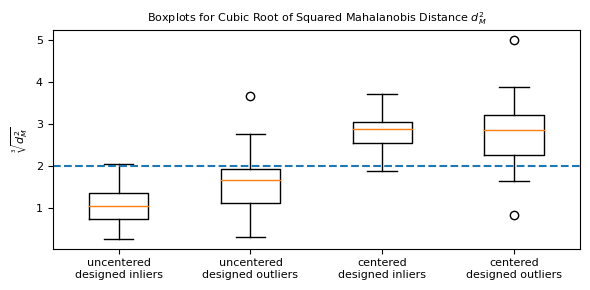

In [6]:
fig, ax = plt.subplots(figsize=(6, 3))
font_size = 8

# inliers
ax.boxplot(
    [
        cbrt_mcd_uncentered[:-n_outliers], 
        cbrt_mcd_uncentered[-n_outliers:], 
        cbrt_mcd_centered[:-n_outliers], 
        cbrt_mcd_centered[-n_outliers:]
    ], 
    labels=[
        'uncentered\ndesigned inliers', 
        'uncentered\ndesigned outliers', 
        'centered\ndesigned inliers', 
        'centered\ndesigned outliers'
    ]
)
ax.hlines(2.0, xmin=0.5, xmax=4.5, ls='--')
ax.tick_params(labelsize=font_size)
ax.set_ylabel('$\sqrt[3]{d_M^2}$', fontsize=font_size)
ax.set_title('Boxplots for Cubic Root of Squared Mahalanobis Distance $d_M^2$', fontsize=font_size)

fig.tight_layout()

From the figure above, we can see centering dataset with respect to the estimated mean will create biases.

## 3.1. Mark Outliers with 2-sigma Bound

In [7]:
cbrt_2sigma_bunch = Bunch()
cbrt_2sigma_bunch.name = 'Mark outliers with 2-sigma bound'

cbrt_2sigma_bunch.cbrt_mahalanobis_dist = np.cbrt(mcd.dist_)
cbrt_2sigma_bunch.threshold_val = 2.0
cbrt_2sigma_bunch.outlier_ind_arr = np.where(
    cbrt_2sigma_bunch.cbrt_mahalanobis_dist>cbrt_2sigma_bunch.threshold_val
)[0]
cbrt_2sigma_bunch.outlier_arr = X[cbrt_2sigma_bunch.outlier_ind_arr, :]

In [8]:
def draw_mahalanobis_ellipse(ax, mu_vec, cov_mat, bound): 
    """
    credit:           
    """
    N = 501
    U, S, Vh = np.linalg.svd(cov_mat)
    theta = np.linspace(0, 2*np.pi, N)

    z = np.zeros((2, N))
    z[0] = np.sqrt(S[0] * bound) * np.cos(theta)
    z[1] = np.sqrt(S[1] * bound) * np.sin(theta)
    viz_x = U @ z + mu_vec[:, np.newaxis]
    ax.plot(
        viz_x[0, :], viz_x[1, :], ls='--', 
        label='Mahalanobis ellipse\nw/ bound at $d_M^2$={:.1f}'.format(bound)
    )

In [9]:
def viz_cbrt_dm_dataset_w_outliers(
    ax, X, n_outliers, outlier_arr, 
    threshold_val, mcd, marker_size, font_size
):
    ax.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], 
        marker='.', s=marker_size, c='black', 
        label='designed inliers'
    )
    ax.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], 
        marker='.', s=marker_size, c='red', 
        label='designed outliers'
    )
    ax.scatter(
        outlier_arr[:, 0], outlier_arr[:, 1], 
        marker='o', s=25, fc='none', ec='blue', 
        label=(
            'threshold: $\sqrt[3]{d_M^2}=$' + 
            '{:.0f}'.format(threshold_val)
        )
    )
    draw_mahalanobis_ellipse(
        ax=ax, mu_vec=mcd.location_, cov_mat=mcd.covariance_, bound=threshold_val**3
    )
    ax.set_xlabel('x', fontsize=font_size)
    ax.set_ylabel('y', fontsize=font_size)
    ax.set_title(
        (
            'Dataset with Outlier Detection\n' + 
            'w/ Threshold $\sqrt[3]{d_M^2}=$' + 
            '{:.0f}'.format(threshold_val)
        ), 
        fontsize=font_size
    )
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=2,
        fontsize=font_size
    )

## 3.2. Mark Outliers with 3-sigma Bound

In [10]:
cbrt_3sigma_bunch = Bunch()
cbrt_3sigma_bunch.name = 'Mark outliers with 3-sigma bound'

cbrt_3sigma_bunch.cbrt_mahalanobis_dist = np.cbrt(mcd.dist_)
cbrt_3sigma_bunch.threshold_val = 3.0
cbrt_3sigma_bunch.outlier_ind_arr = np.where(
    cbrt_3sigma_bunch.cbrt_mahalanobis_dist>cbrt_3sigma_bunch.threshold_val
)[0]
cbrt_3sigma_bunch.outlier_arr = X[cbrt_3sigma_bunch.outlier_ind_arr, :]

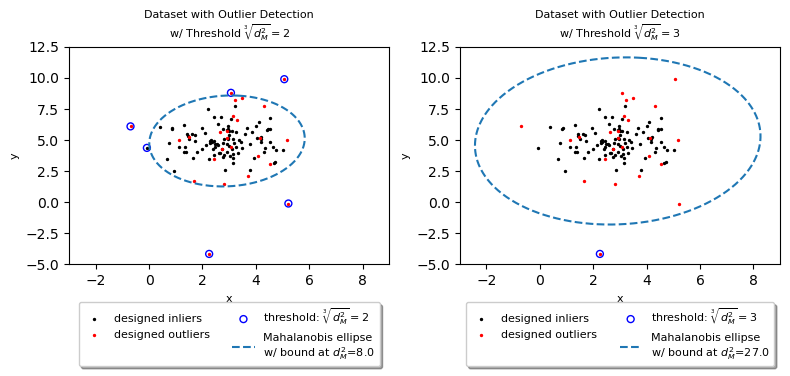

In [11]:
# visualize data with outliers
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
marker_size = 8
font_size = 8
xlim = [-3, 9]
ylim = [-5, 12.5]

viz_cbrt_dm_dataset_w_outliers(
    axes[0], X, n_outliers, 
    cbrt_2sigma_bunch.outlier_arr, 
    cbrt_2sigma_bunch.threshold_val, 
    mcd, marker_size, font_size
)

viz_cbrt_dm_dataset_w_outliers(
    axes[1], X, n_outliers, 
    cbrt_3sigma_bunch.outlier_arr, 
    cbrt_3sigma_bunch.threshold_val, 
    mcd, marker_size, font_size
)

for ax in axes.reshape(-1):
    ax.set(xlim=xlim, ylim=ylim)

fig.tight_layout()

# 4. Squared Mahalanobis Distance

In [12]:
def viz_dm_dataset_w_outliers(
    ax, X, n_outliers, outlier_arr, percentile_threshold_val, 
    threshold_val, mcd, marker_size, font_size
):
    ax.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], 
        marker='.', s=marker_size, c='black', 
        label='designed inliers'
    )
    ax.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], 
        marker='.', s=marker_size, c='red', 
        label='designed outliers'
    )
    ax.scatter(
        outlier_arr[:, 0], outlier_arr[:, 1], 
        marker='o', s=25, fc='none', ec='blue', 
        label=(
            'threshold: $d_M^2=$' + 
            '{:.0f}'.format(threshold_val)
        )
    )
    draw_mahalanobis_ellipse(
        ax=ax, mu_vec=mcd.location_, cov_mat=mcd.covariance_, bound=threshold_val
    )
    ax.set_xlabel('x', fontsize=font_size)
    ax.set_ylabel('y', fontsize=font_size)
    ax.set_title(
        (
            'Dataset with Outlier Detection\n' + 
            'w/ Percentile {:.1f}%'.format(100*percentile_threshold_val) + 
            ', Threshold $\sqrt[3]{d_M^2}=$' + 
            '{:.0f}'.format(threshold_val)
        ), 
        fontsize=font_size
    )
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=2,
        fontsize=font_size
    )

## 4.1. Mark Outliers with 97.5% Percentile

In [13]:
chi2_975_bunch = Bunch()
chi2_975_bunch.name = 'Mark outliers with 97.5% percentile'

chi2_975_bunch.mahalanobis_dist_squared = mcd.dist_
chi2_975_bunch.percentile_threshold_val = 0.975
chi2_975_bunch.threshold_val = chi2.ppf(chi2_975_bunch.percentile_threshold_val, df=2)
chi2_975_bunch.outlier_ind_arr = np.where(
    chi2_975_bunch.mahalanobis_dist_squared>chi2_975_bunch.threshold_val
)[0]
chi2_975_bunch.outlier_arr = X[chi2_975_bunch.outlier_ind_arr, :]

## 4.2. Mark Outliers with 99.5% Percentile

In [14]:
chi2_995_bunch = Bunch()
chi2_995_bunch.name = 'Mark outliers with 99.5% percentile'

chi2_995_bunch.mahalanobis_dist_squared = mcd.dist_
chi2_995_bunch.percentile_threshold_val = 0.995
chi2_995_bunch.threshold_val = chi2.ppf(chi2_995_bunch.percentile_threshold_val, df=2)
chi2_995_bunch.outlier_ind_arr = np.where(
    chi2_995_bunch.mahalanobis_dist_squared>chi2_995_bunch.threshold_val
)[0]
chi2_995_bunch.outlier_arr = X[chi2_995_bunch.outlier_ind_arr, :]

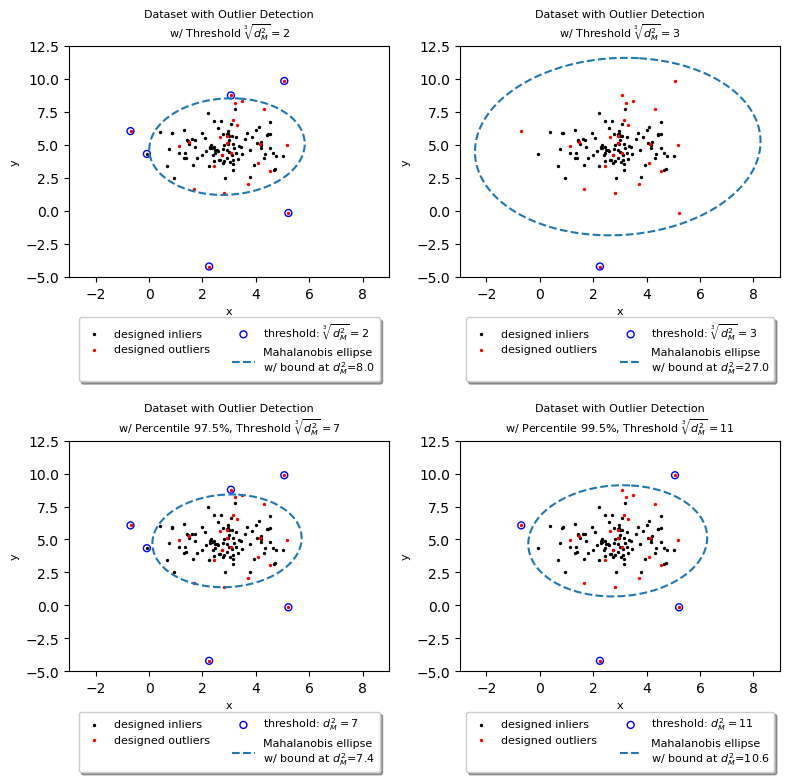

In [15]:
# visualize data with outliers
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
marker_size = 8
font_size = 8
xlim = [-3, 9]
ylim = [-5, 12.5]

viz_cbrt_dm_dataset_w_outliers(
    axes[0, 0], X, n_outliers, 
    cbrt_2sigma_bunch.outlier_arr, 
    cbrt_2sigma_bunch.threshold_val, 
    mcd, marker_size, font_size
)

viz_cbrt_dm_dataset_w_outliers(
    axes[0, 1], X, n_outliers, 
    cbrt_3sigma_bunch.outlier_arr, 
    cbrt_3sigma_bunch.threshold_val, 
    mcd, marker_size, font_size
)

viz_dm_dataset_w_outliers(
    axes[1, 0], X, n_outliers, 
    chi2_975_bunch.outlier_arr, 
    chi2_975_bunch.percentile_threshold_val, 
    chi2_975_bunch.threshold_val, 
    mcd, marker_size, font_size
)

viz_dm_dataset_w_outliers(
    axes[1, 1], X, n_outliers, 
    chi2_995_bunch.outlier_arr, 
    chi2_995_bunch.percentile_threshold_val, 
    chi2_995_bunch.threshold_val, 
    mcd, marker_size, font_size
)

for ax in axes.reshape(-1):
    ax.set(xlim=xlim, ylim=ylim)

fig.tight_layout()

# 5. Utilize `EllipticEnvelope` Method

In [16]:
def viz_ee_dataset_w_outliers(
    ax, X, n_outliers, outlier_arr, 
    contamination, ee, marker_size, font_size, 
    xlim, ylim
):
    ax.scatter(
        X[:-n_outliers, 0], X[:-n_outliers, 1], 
        marker='.', s=marker_size, c='black', 
        label='designed inliers'
    )
    ax.scatter(
        X[-n_outliers:, 0], X[-n_outliers:, 1], 
        marker='.', s=marker_size, c='red', 
        label='designed outliers'
    )
    ax.scatter(
        outlier_arr[:, 0], outlier_arr[:, 1], 
        marker='o', s=25, fc='none', ec='blue', 
        label=(
            'contamination={:.2f}'.format(contamination)
        )
    )
    
    # draw bounds
    xx, yy = np.meshgrid(
        np.linspace(xlim[0], xlim[1], 501), 
        np.linspace(ylim[0], ylim[1], 501)
    )
    Z = ee.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z, levels=[0], linewidths=0.5, colors='black')
    
    ax.set_xlabel('x', fontsize=font_size)
    ax.set_ylabel('y', fontsize=font_size)
    ax.set(xlim=xlim, ylim=ylim)
    ax.set_title(
        (
            'Dataset with Outlier Detection\n' + 
            'w/ contamination={:.2f}'.format(contamination)
        ), 
        fontsize=font_size
    )
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=2,
        fontsize=font_size
    )

## 5.1. 10% of Contamination

In [17]:
ee_10_bunch = Bunch()
ee_10_bunch.name = 'Mark outliers with 10% contamination'

ee_10_bunch.contamination = 0.1
ee_10_bunch.ee = EllipticEnvelope(
    random_state=rs_num, contamination=ee_10_bunch.contamination
).fit(X)

ee_10_bunch.outlier_ind_arr = np.where(
    ee_10_bunch.ee.predict(X)==-1
)[0]
ee_10_bunch.outlier_arr = X[ee_10_bunch.outlier_ind_arr, :]

## 5.2. 1% of Contamination

In [18]:
ee_01_bunch = Bunch()
ee_01_bunch.name = 'Mark outliers with 1% contamination'

ee_01_bunch.contamination = 0.01
ee_01_bunch.ee = EllipticEnvelope(
    random_state=rs_num, contamination=ee_01_bunch.contamination
).fit(X)

ee_01_bunch.outlier_ind_arr = np.where(
    ee_01_bunch.ee.predict(X)==-1
)[0]
ee_01_bunch.outlier_arr = X[ee_01_bunch.outlier_ind_arr, :]

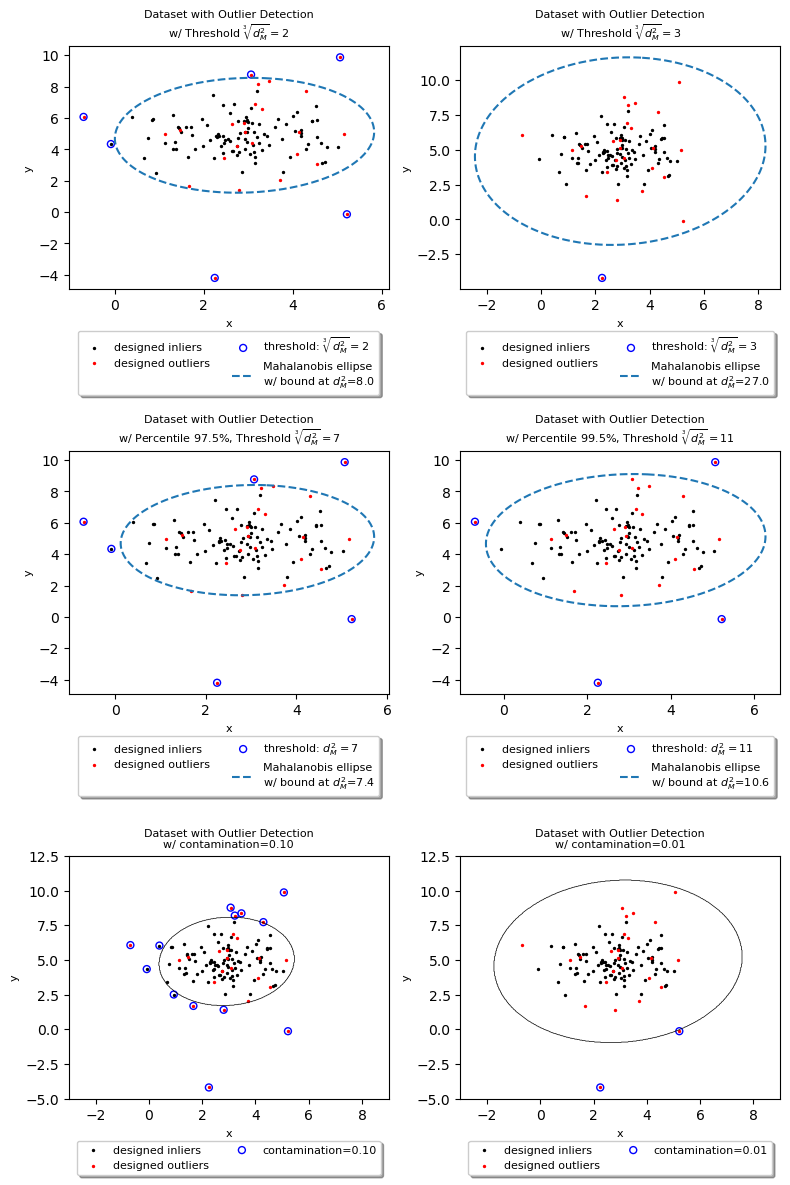

In [19]:
# visualize data with outliers
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
marker_size = 8
font_size = 8
xlim = [-3, 9]
ylim = [-5, 12.5]

viz_cbrt_dm_dataset_w_outliers(
    axes[0, 0], X, n_outliers, 
    cbrt_2sigma_bunch.outlier_arr, 
    cbrt_2sigma_bunch.threshold_val, 
    mcd, marker_size, font_size
)

viz_cbrt_dm_dataset_w_outliers(
    axes[0, 1], X, n_outliers, 
    cbrt_3sigma_bunch.outlier_arr, 
    cbrt_3sigma_bunch.threshold_val, 
    mcd, marker_size, font_size
)

viz_dm_dataset_w_outliers(
    axes[1, 0], X, n_outliers, 
    chi2_975_bunch.outlier_arr, 
    chi2_975_bunch.percentile_threshold_val, 
    chi2_975_bunch.threshold_val, 
    mcd, marker_size, font_size
)

viz_dm_dataset_w_outliers(
    axes[1, 1], X, n_outliers, 
    chi2_995_bunch.outlier_arr, 
    chi2_995_bunch.percentile_threshold_val, 
    chi2_995_bunch.threshold_val, 
    mcd, marker_size, font_size
)

viz_ee_dataset_w_outliers(
    axes[2, 0], X, n_outliers, ee_10_bunch.outlier_arr, 
    ee_10_bunch.contamination, ee_10_bunch.ee, 
    marker_size, font_size, xlim, ylim
)

viz_ee_dataset_w_outliers(
    axes[2, 1], X, n_outliers, ee_01_bunch.outlier_arr, 
    ee_01_bunch.contamination, ee_01_bunch.ee, 
    marker_size, font_size, xlim, ylim
)

fig.tight_layout()